## Random Fourier Features based SLAM: Experiments

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
import sys

sys.path.append('../src')

from random_features import RFF

from data_utils import Landscape
from data_utils import Odometry
from model import Model
from observation import RangeModel 
from data_utils import get_prediction

In [4]:
def APE_trans(true_states, model_states):
    return np.sqrt(np.linalg.norm(model_states[:, :2] / true_states[:, :2]) ** 2 / len(true_states))

In [5]:
def APE_rot(true_states, model_states):
    return np.sqrt(np.linalg.norm(model_states[:, 2] / true_states[:, 2]) ** 2 / len(true_states))

### Replication of graphs from the paper

In [6]:
np.random.seed(42)

In [7]:
def train_range_only(n_features = 100, num_landmarks = 20, N_pts = 100, 
                     observation_dim = 3, max_time = 10, beta = np.array([1.0, 1.0])):
    
    # Set RFF sampler
    sampler = lambda shape: multivariate_normal(mean = [0], 
                                                cov = (1./3**2) * np.eye(1)).rvs(size = np.product(shape))
    assert n_features % 2 == 0
    rff = RFF(n_features = n_features // 2, w_sampler=sampler, dim=1)

    # Set landscape
    landscape = Landscape(num_landmarks = num_landmarks)
    landscape.initialize()

    # Odometry
    odometry = Odometry(landscape, observation_dim = observation_dim, max_time = max_time, beta = beta)
    odometry.generate(N_pts)
    
    def prior_mean(t, state_estimates):
        i = odometry.times.index(t)
        state = get_prediction(state_estimates[i], odometry.motions[i])
        return state
    
    range_model = RangeModel(odometry.Q[0, 0])
    initial_values = np.concatenate([np.zeros(n_features * 3), landscape.landmarks.reshape(-1)])
    b_means = np.concatenate([np.zeros(n_features * 3), landscape.landmarks.reshape(-1)])

    model = Model(rff=rff, 
                  initial_values=initial_values,
                  initial_state=odometry.states[0],
                  times=odometry.times,
                  measurements=np.stack(odometry.observations, 0)[:, 0, [0, 2]],
                  measurement_covs=[odometry.Q[:1, :1]]*N_pts,
                  motions=odometry.motions,
                  b_means=b_means,
                  b_covs=[0.01*np.eye(n_features)]*3,
                  land_means=landscape.landmarks,
                  land_cov=[0.01*np.eye(2)]*len(landscape.landmarks),
                  observation_model=range_model,
                  prior_mean=prior_mean,
                  dampening_factor=0.01)
    
    model.run_slam(100)
    return np.array(odometry.states[1:]), np.array(model.states)

In [15]:
def train_range_only(
                    landscape = None,
                    odometry = None,
                    n_features = 100, 
                    num_landmarks = 20, 
                    N_pts = 100,  
                    max_time = 10,
                    alphas = np.array([0.05, 0.001, 0.05, 0.01]),
                    beta = np.array([1.0, 1.0]),
                    n_iter = 100,
                    ):

    state_dim = 3
    landmark_dim = 2
    obs_dim = 1

    sigma_l = 3.
    b_sigma = 0.1
    land_sigma = 0.1
    damppening_factor = 0.01

    # Set landscape
    if landscape is None:
        landscape = Landscape(num_landmarks = num_landmarks)
        landscape.initialize()

    # Odometry
    if odometry is None:
        odometry = Odometry(landscape, observation_dim = 3, max_time = max_time, beta = beta, alphas = alphas)
        odometry.generate(N_pts)
    
    # Set RFF sampler
    sampler = lambda shape: multivariate_normal(mean = [0], 
                                                cov = (1./sigma_l**2) * np.eye(1)
                                                ).rvs(size = np.product(shape))
    assert n_features % 2 == 0
    rff = RFF(n_features = n_features // 2, w_sampler=sampler, dim=1)

    range_model = RangeModel(range_noise_std=odometry.Q[0,0]**.5)

    def prior_mean(t, state_estimates):
        i = odometry.times.index(t)
        state = get_prediction(state_estimates[i], odometry.motions[i])
        return state

    #initial_values = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])
    initial_values = np.zeros((n_features*state_dim)+len(landscape.landmarks)*landmark_dim)
    b_means = np.concatenate([np.zeros(n_features*state_dim), landscape.landmarks.reshape(-1)])

    observations = range_model.get_range_observations(odometry.observations)

    model = Model(rff=rff, 
                initial_values=initial_values,
                initial_state=odometry.states[0],
                times=odometry.times,
                measurements=observations,
                measurement_covs=[odometry.Q[:1, :1]] * N_pts,
                motions=odometry.motions,
                b_means=b_means,
                b_covs=[b_sigma**2 * np.eye(n_features)] * state_dim,
                land_means=landscape.landmarks,
                land_cov=[land_sigma**2 * np.eye(landmark_dim)] * len(landscape.landmarks),
                observation_model=range_model,
                prior_mean=prior_mean,
                dampening_factor=damppening_factor,
                )

    model.run_slam(n_iter=n_iter)
    return np.array(odometry.states[1:]), np.array(model.states)

In [16]:
results_trans = np.zeros((5, 4))
results_rot = np.zeros((5, 4))

i, j = 0, 0
for noise in [1, 2, 3, 4, 5]:
    for num_landmarks in [5, 10, 20, 30]:
        true_st, mod_st = train_range_only(n_features = 100, num_landmarks = num_landmarks)
        results_trans[i, j] = APE_trans(true_st, mod_st)
        results_rot[i, j] = APE_rot(true_st, mod_st)
        j += 1
    i+= 1
    j = 0

tion: 0.5074
Norm of perturbation: 0.5065
Norm of perturbation: 0.5190
Norm of perturbation: 0.4520
Norm of perturbation: 0.4666
Norm of perturbation: 0.4295
Norm of perturbation: 0.4392
Norm of perturbation: 0.5014
Norm of perturbation: 0.4084
Norm of perturbation: 0.3794
Norm of perturbation: 0.4291
Norm of perturbation: 0.4330
Norm of perturbation: 0.4719
Norm of perturbation: 0.3833
Norm of perturbation: 0.3465
Norm of perturbation: 0.3842
Norm of perturbation: 0.3343
Norm of perturbation: 0.3434
Norm of perturbation: 0.3135
Norm of perturbation: 0.3211
Norm of perturbation: 0.2845
Norm of perturbation: 0.3283
Norm of perturbation: 0.2765
Norm of perturbation: 0.2317
Norm of perturbation: 0.2502
Norm of perturbation: 0.1971
Norm of perturbation: 0.2544
Norm of perturbation: 0.2637
Norm of perturbation: 0.2479
Norm of perturbation: 0.2426
Norm of perturbation: 0.2358
Norm of perturbation: 0.2645
Norm of perturbation: 0.2532
Norm of perturbation: 0.2667
Norm of perturbation: 0.2662
N

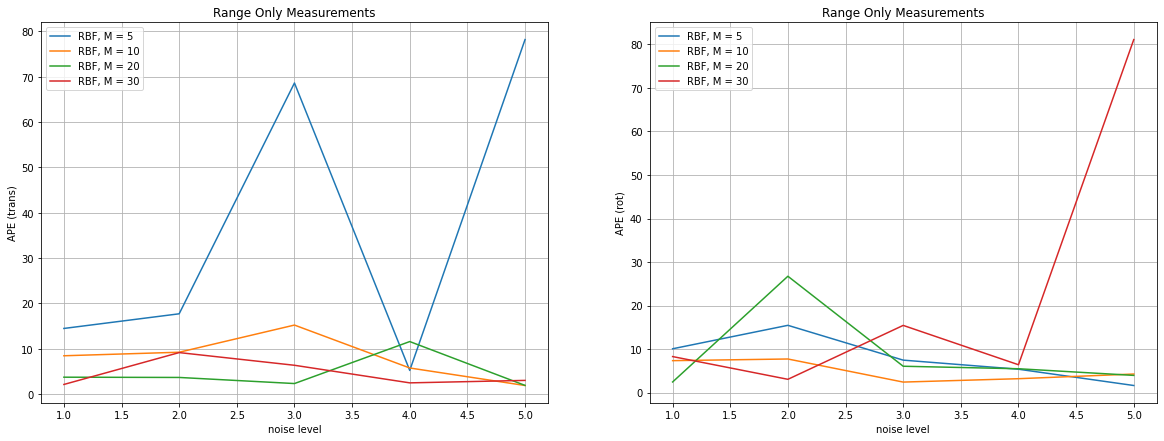

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
num_landm = [5, 10, 20, 30]

noise = np.arange(1, 6)
for i in range(results_trans.shape[1]):
    ax[0].plot(noise, results_trans[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[0].legend()
    ax[0].grid('black')
    ax[0].set_xlabel('noise level')
    ax[0].set_ylabel('APE (trans)')
    ax[0].set_title('Range Only Measurements')
    
    ax[1].plot(noise, results_rot[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[1].legend()
    ax[1].grid('black')
    ax[1].set_xlabel('noise level')
    ax[1].set_ylabel('APE (rot)')
    ax[1].set_title('Range Only Measurements')

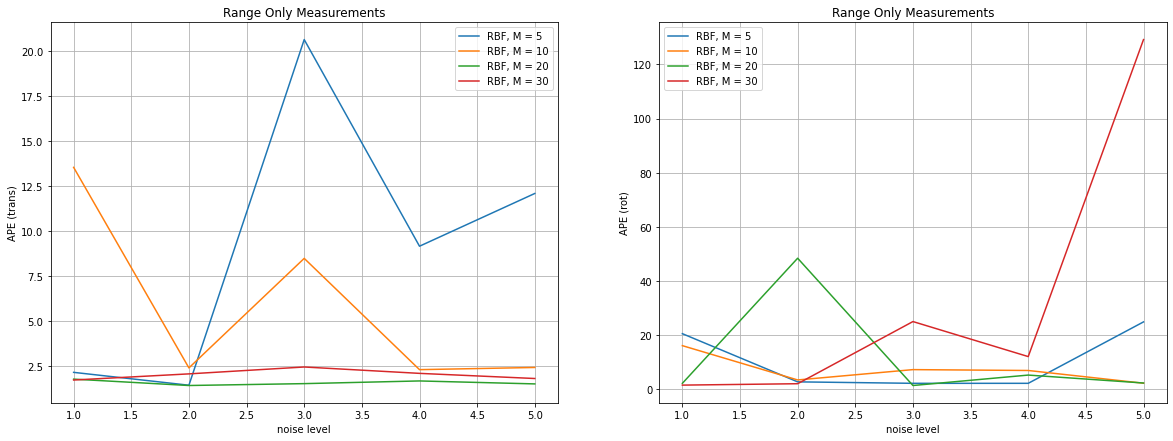

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
num_landm = [5, 10, 20, 30]

noise = np.arange(1, 6)
for i in range(results_trans.shape[1]):
    ax[0].plot(noise, results_trans[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[0].legend()
    ax[0].grid('black')
    ax[0].set_xlabel('noise level')
    ax[0].set_ylabel('APE (trans)')
    ax[0].set_title('Range Only Measurements')
    
    ax[1].plot(noise, results_rot[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[1].legend()
    ax[1].grid('black')
    ax[1].set_xlabel('noise level')
    ax[1].set_ylabel('APE (rot)')
    ax[1].set_title('Range Only Measurements')

In [16]:
np.array(odometry.states[1:11])#, np.array(odometry.states[:10])+np.array(odometry.motions[:10])

array([[ 2.52731892,  0.36200641,  0.44060008],
       [ 3.25373398,  0.572977  ,  0.38948858],
       [ 3.93968426,  0.79370143,  0.28893434],
       [ 4.54973988,  0.94851426,  0.24501191],
       [ 5.54068785,  1.25072336,  0.16300864],
       [ 6.51168279,  1.34874287,  0.0670283 ],
       [ 7.60583601,  1.55362468,  0.10003805],
       [15.12754903,  3.34762188,  1.20232216],
       [15.29252361,  4.60204357,  1.5544871 ],
       [14.94366171,  5.80403561,  1.82490413]])

In [17]:
model.prior_means[:10]

[array([2.15699628, 0.21197819, 0.44852944]),
 array([2.93214244, 0.48036556, 0.3928904 ]),
 array([3.91941479, 0.77905282, 0.28248002]),
 array([4.84739088, 1.00453528, 0.23196029]),
 array([5.90702728, 1.28739403, 0.12925126]),
 array([6.99891529, 1.49951535, 0.10083755]),
 array([8.0223155 , 1.78283776, 0.11496425]),
 array([9.27886939, 2.43107318, 0.49658111]),
 array([10.41018223,  3.54527817,  0.85975188]),
 array([11.19950397,  4.82362608,  1.05833625])]

In [18]:
model.states[:10]

array([[ 2.27864256,  0.2722652 ,  0.44990294],
       [ 3.05474743,  0.54242463,  0.39427224],
       [ 4.04064182,  0.83115822,  0.28382489],
       [ 4.96438267,  1.05032426,  0.23335302],
       [ 6.03381911,  1.3656993 ,  0.13061136],
       [ 7.11040139,  1.56236818,  0.10218331],
       [ 8.13631286,  1.86584493,  0.11631624],
       [ 9.38423252,  2.50190909,  0.49786765],
       [10.52117693,  3.59187005,  0.86105407],
       [11.3141428 ,  4.89608086,  1.05953313]])

In [19]:
model.b[300:].reshape(-1, 2), landscape.landmarks

(array([[ 6.54200597,  1.36002707],
        [ 7.80736414, -6.06406756],
        [-9.8279496 , -4.38658407],
        [-7.99389258,  1.33607624],
        [ 8.10215701,  0.97329082],
        [ 7.98913478,  6.94455757],
        [-9.35457719, -1.2027493 ],
        [ 6.16684237, -7.62167963],
        [-1.48649354, -5.90698284],
        [-6.95788406, -6.16608108],
        [-1.20281256,  6.18088094],
        [ 7.26690028, -8.46348889],
        [-3.00990526, -7.90223288],
        [-6.39447331, -2.49315901],
        [ 3.23405096, -8.5377894 ],
        [-8.21565702,  1.2222821 ],
        [ 8.30255221,  1.99396093],
        [-6.97417318,  7.78916788],
        [ 5.8180511 ,  6.86090545],
        [ 3.25948821,  5.50458738]]),
 array([[ 6.54230384,  1.35999629],
        [ 7.8073209 , -6.06452507],
        [-9.82951532, -4.38816772],
        [-7.99132568,  1.33736625],
        [ 8.10192792,  0.97400377],
        [ 7.9892356 ,  6.94722973],
        [-9.35505109, -1.20317407],
        [ 6.1668149 , -7.6